In [1]:
import numpy as np
import random
import math
import copy
from YenAlgorithm import YenAlgorithm

class Solution(object):
    def __init__(self):
        self.path = []
        self.code = []
        self.fitness = float('inf')
        self.fitness_vector = 0
        self.counter = 0
        self.prob = 0

class ABC:

    def __init__(self, src, dst, N, Max, K_paths):
        self.switches = [i for i in range(1,11)]
        self.src= src
        self.dst = dst
        self.weight_map= self.GetWeightMap()
        self.adjacency = copy.deepcopy(self.weight_map)
        self.N = N
        self.Max = Max
        self.K_paths = K_paths
        self.population = [self.CreateSolution() for i in range(self.N)]
        self.limit = int(math.sqrt(N+len(self.switches)))
        self.condidates = []
        self.best = []
    
    def GetWeightMap(self):
        weight_map={}
        temp = 0
        with open('metric_data_10.txt') as f:
            for line in f:
                strt = line
                strt2 = strt.split(':')
                my_result = list(map(int, strt2[0].split(',')))
                if (temp!=my_result[0]):
                    weight_map[my_result[0]]={}
                weight_map[my_result[0]][my_result[1]] = int(strt2[1])
                temp = my_result[0]
        return weight_map

    def CreateSolution(self):
        newSolution = Solution()
        path=[]
        code = []
        while(len(path)==0):
            code.clear()
            path.clear()
            code = copy.deepcopy([random.uniform(-1,1) for i in range(len(self.switches))])
            path = copy.deepcopy(self.Decode(code))
        newSolution.code = copy.deepcopy(code)
        newSolution.path = copy.deepcopy(path)
        newSolution.fitness = self.Evaluate(newSolution.path)
        return newSolution
    
    def Decode(self,code):
        path = []
        path.append(self.src)
        current_switch = self.src
        while(current_switch!=self.dst):
            neighbor_switches = set(self.adjacency[current_switch].keys())-set(path)
            neighbor_switches = list(neighbor_switches)
            if(len(neighbor_switches)==0):
                path.clear()
                break
            switch_min = 1
            min = float('inf')
            for switch in neighbor_switches:
                if(code[switch-1] <= min):
                    min = code[switch-1]
                    switch_min = switch
            current_switch = switch_min
            path.append(current_switch)
        return path

    def Evaluate(self,path):
        calculatedFitness = 0
        for i in range(len(path) - 1):
            p1 = path[i]
            p2 = path[i + 1]
            calculatedFitness += self.weight_map[p1][p2]
        return calculatedFitness
    
    def Normalize(self,code):
        code_2 = copy.deepcopy(code)
        mn = min(code_2)
        mx = max(code_2)
        for j in range(len(self.switches)):
            code[j] = -1+2*(code_2[j]-mn)/(mx-mn)
        return code

    def InitializationPhase(self):
        for i in range(self.N):
            mn = min(self.population[i].code)
            mx = max(self.population[i].code)
            self.population[i].code.clear()
            path=[]
            code = []
            while(len(path)==0):
                code.clear()
                path.clear()
                code = copy.deepcopy([(mn+np.random.rand()*(mx-mn)) for i in range(len(self.switches))])
                path = copy.deepcopy(self.Decode(code))
            self.population[i].code = copy.deepcopy(code)
            self.population[i].path = copy.deepcopy(path)
            self.population[i].fitness = self.Evaluate(self.population[i].path)
    
    def EmployeedPhase(self):
        population = copy.deepcopy(self.population)
        for i in range(self.N):
            r = list(range(0,i)) + list(range(i+1,self.N))
            coceg = random.choice(r)
            solution = copy.deepcopy(self.population[i])
            code = copy.deepcopy(self.population[i].code)
            path = []
            d = np.random.randint(len(self.switches)-1)
            while(len(path)==0):
                fi = random.uniform(-1,1)
                for ii in range(len(self.switches)):
                    if(ii==d):
                        code[ii] = solution.code[ii]+fi*(solution.code[ii]-self.population[coceg].code[ii])
                    else:
                        code[ii] = solution.code[ii]
                code = self.Normalize(code)
                path = copy.deepcopy(self.Decode(code))
            solution.code = copy.deepcopy(code)
            solution.path = copy.deepcopy(path)
            solution.fitness = self.Evaluate(solution.path)
            if(solution.fitness<population[i].fitness):
                solution.counter = 0
                population[i] = copy.deepcopy(solution)
            else:
                population[i].counter+=1
        self.population=copy.deepcopy(population)

    def OnlookedPhase(self):
        for i in range(self.N):
            self.population[i].fitness_vector = 1/self.population[i].fitness
        sum = 0
        for i in range(self.N):
            sum+=self.population[i].fitness_vector
        prob=[]
        for i in range(self.N):
            self.population[i].prob=self.population[i].fitness_vector/sum
        for i in range(self.N):
            prob.append(self.population[i].prob)
        population= copy.deepcopy(self.population)
        for i in range(self.N):
            index_solution = np.random.choice(list(range(self.N)),p=prob)
            r = list(range(0,index_solution)) + list(range(index_solution+1,self.N))
            coceg = random.choice(r)
            solution = copy.deepcopy(self.population[index_solution])
            code =copy.deepcopy(solution.code)
            path = []
            d = np.random.randint(len(self.switches)-1)
            while(len(path)==0):
                fi = random.uniform(-1,1)
                for ii in range(len(self.switches)):
                    if(ii==d):
                        code[ii] = solution.code[ii]+fi*(solution.code[ii]-self.population[coceg].code[ii])
                    else:
                        code[ii] = solution.code[ii]
                code = self.Normalize(code)
                path = copy.deepcopy(self.Decode(code))
            solution.code = copy.deepcopy(code)
            solution.path = copy.deepcopy(path)
            solution.fitness = self.Evaluate(solution.path)
            if(solution.fitness<population[index_solution].fitness):
                solution.counter = 0
                population[index_solution] = copy.deepcopy(solution)
            else:
                population[index_solution].counter+=1
        self.population=copy.deepcopy(population)

    def ScoutPhase(self):
        for i in range(self.N):
            if self.population[i].counter > self.limit:
                self.population[i] = copy.deepcopy(self.CreateSolution())
    
    def MemorizeCondidates(self):
        self.population.sort(key=lambda x: x.fitness)
        condidate = []
        k=0
        for i in range(len(self.population)):
            dk_3 = False
            for member in condidate:
                if(tuple(member.path)==tuple(self.population[i].path)):
                    dk_3 = True
                    break
            if(dk_3!=True):
                condidate.append(copy.deepcopy(self.population[i]))
                k=k+1
            if(k==self.K_paths):
                break
        self.condidates.extend(copy.deepcopy(condidate))
    
    def GetBest(self):
        self.condidates.sort(key=lambda x: x.fitness)
        self.best.clear()
        k=0
        for i in range(len(self.condidates)):
            dk_3 = False
            for solution in self.best:
                if(tuple(solution.path)==tuple(self.condidates[i].path)):
                    dk_3 = True
                    break
            if(dk_3!=True):
                self.best.append(copy.deepcopy(self.condidates[i]))
                k=k+1
            if(k==self.K_paths):
                break

    def Do(self):
        self.InitializationPhase()
        for i in range(self.Max):
            self.EmployeedPhase()
            self.OnlookedPhase()
            self.ScoutPhase()
            self.MemorizeCondidates()
        self.GetBest()

In [2]:
import numpy as np
import random
import math
import copy
from YenAlgorithm import YenAlgorithm

class Genome(object):
    def __init__(self):
        self.path = []
        self.fitness = float('inf')

class GA:

    def __init__(self, src, dst, N, Max, K_paths, Pc, Pm, Ts):
        self.switches = [i for i in range(1,11)]
        self.src= src
        self.dst = dst
        self.weight_map= self.GetWeightMap()
        self.adjacency = copy.deepcopy(self.weight_map)
        self.N = N
        self.Max = Max
        self.Pm = Pm
        self.Pc = Pc
        self.K_paths = K_paths
        self.population = [self.CreateGenome() for i in range(self.N)]
        self.condidates = []
        self.best = []
        self.Ts = Ts
    
    def GetWeightMap(self):
        weight_map={}
        temp = 0
        with open('metric_data_10.txt') as f:
            for line in f:
                strt = line
                strt2 = strt.split(':')
                my_result = list(map(int, strt2[0].split(',')))
                if (temp!=my_result[0]):
                    weight_map[my_result[0]]={}
                weight_map[my_result[0]][my_result[1]] = int(strt2[1])
                temp = my_result[0]
        return weight_map

    def CreateGenome(self):
        newGenome = Genome()
        newGenome.path.append(self.src)
        current_switch = self.src
        while(current_switch!=self.dst):
            neighbor_switches = set(self.adjacency[current_switch].keys())-set(newGenome.path)
            neighbor_switches = list(neighbor_switches)
            if(len(neighbor_switches)==0):
                newGenome.path.clear()
                current_switch = self.src
                newGenome.path.append(self.src)
            else:
                next_switch = random.choice(neighbor_switches)
                newGenome.path.append(next_switch)
                current_switch = next_switch
        newGenome.fitness = self.Evaluate(newGenome.path)
        return newGenome

    def Evaluate(self,path):
        calculatedFitness = 0
        for i in range(len(path) - 1):
            p1 = path[i]
            p2 = path[i + 1]
            calculatedFitness += self.weight_map[p1][p2]
        return calculatedFitness
    
    def CorrectGenome(self,genome):
        dk = False
        for i in range(1,len(genome.path)-2):
            for j in range(i+1,len(genome.path)-1):
                if(genome.path[i]==genome.path[j]):
                    del genome.path[i+1:j+1]
                    dk = True
                    break
            if(dk==True):
                break
        return genome
    
    def ExchangeGenes(self, parents_1, parents_2):
        dk = False
        for i in range(1,len(parents_1.path)-1):
            for j in range(1,len(parents_2.path)-1):
                if(parents_1.path[i]==parents_2.path[j]):
                    tail_1 = copy.deepcopy(parents_1.path[i+1:])
                    tail_2 = copy.deepcopy(parents_2.path[j+1:])
                    del parents_1.path[i+1:]
                    del parents_2.path[j+1:]
                    parents_1.path.extend(tail_2)
                    parents_2.path.extend(tail_1)
                    dk = True
                    break
            if(dk==True):
                break
        return parents_1, parents_2
    
    def Crossover(self):
        children = []
        for i in range(0,self.N,2):
            father = random.randint(0,self.N-1)
            mother = random.randint(0,self.N-1)
            parents_1 = copy.deepcopy(self.population[father])
            parents_2 = copy.deepcopy(self.population[mother])
            if random.uniform(0,1) < self.Pc:
                child_1, child_2 = self.ExchangeGenes(parents_1, parents_2)
                child_1 = self.CorrectGenome(child_1)
                child_2  = self.CorrectGenome(child_2 )
                child_1.fitness = self.Evaluate(child_1.path)
                child_2.fitness = self.Evaluate(child_2.path)
                children.append(copy.deepcopy(child_1))
                children.append(copy.deepcopy(child_2))
            else:
                children.append(copy.deepcopy(parents_1))
                children.append(copy.deepcopy(parents_2))
        self.population = copy.deepcopy(children)
    
    def Mutation(self):
        for i in range(len(self.population)):
            if random.uniform(0,1) < self.Pm:
                parents = copy.deepcopy(self.population[i]) 
                ls = list(range(1,len(parents.path)-1))
                point_mutation = random.choice(ls)
                current_switch = parents.path[point_mutation]
                del parents.path[point_mutation+1:]
                save_parents = copy.deepcopy(parents.path)
                while(current_switch!=self.dst):
                    neighbor_switches = set(self.adjacency[current_switch].keys())-set(parents.path)
                    neighbor_switches = list(neighbor_switches)
                    if(len(neighbor_switches)==0):
                        parents.path = copy.deepcopy(save_parents)
                        current_switch = parents.path[point_mutation]
                    else:
                        next_switch = random.choice(neighbor_switches)
                        parents.path.append(next_switch)
                        current_switch = next_switch
                parents.fitness = self.Evaluate(parents.path)
                self.population[i] = copy.deepcopy(parents)
                
    def Selection(self):
        selected_population=[]
        for i in range(self.N):
            selected_index = np.random.randint(0,len(self.population)-1)
            for ix in np.random.randint(0,len(self.population)-1,self.Ts-1):
                if(self.population[ix].fitness<self.population[selected_index].fitness):
                    selected_index = ix
            selected_population.append(self.population[selected_index])
        self.population = copy.deepcopy(selected_population)
    
    def MemorizeCondidates(self):
        self.population.sort(key=lambda x: x.fitness)
        condidate = []
        k=0
        for i in range(len(self.population)):
            dk_3 = False
            for genome in condidate:
                if(tuple(genome.path)==tuple(self.population[i].path)):
                    dk_3 = True
                    break
            if(dk_3!=True):
                condidate.append(copy.deepcopy(self.population[i]))
                k=k+1
            if(k==self.K_paths):
                break
        self.condidates.extend(copy.deepcopy(condidate))
    
    def GetBest(self):
        self.condidates.sort(key=lambda x: x.fitness)
        self.best.clear()
        k=0
        for i in range(len(self.condidates)):
            dk_3 = False
            for genome in self.best:
                if(tuple(genome.path)==tuple(self.condidates[i].path)):
                    dk_3 = True
                    break
            if(dk_3!=True):
                self.best.append(copy.deepcopy(self.condidates[i]))
                k=k+1
            if(k==self.K_paths):
                break
    
    def Do(self):
        for i in range(self.Max):
            self.Crossover()
            self.Mutation()
            self.Selection()
            self.MemorizeCondidates()
        self.GetBest()

In [3]:
Times = 100
N = 30
Max = 100
K_paths = 10
Pc = 0.8
Pm = 0.1
Ts = 2

In [4]:
weight_map={}
temp = 0
with open('metric_data_10.txt') as f:
    for line in f:
        strt = line
        strt2 = strt.split(':')
        my_result = list(map(int, strt2[0].split(',')))
        if (temp!=my_result[0]):
            weight_map[my_result[0]]={}
        weight_map[my_result[0]][my_result[1]] = int(strt2[1])
        temp = my_result[0]
vertices = [i for i in range(1,11)]
alg_y = YenAlgorithm(weight_map,vertices,1,4,K_paths)
paths_vertices = alg_y.compute_shortest_paths()

In [5]:
paths_length = []
for path in paths_vertices:
    s = 0
    for i in range(len(path)-1):
        s+= weight_map[path[i]][path[i+1]]
    paths_length.append(s)
print(paths_length)
paths_vertices

[170, 170, 180, 190, 200, 200, 210, 210, 220, 220]


[[1, 8, 9, 10, 4],
 [1, 8, 9, 3, 4],
 [1, 8, 9, 10, 3, 4],
 [1, 2, 3, 4],
 [1, 8, 9, 2, 3, 4],
 [1, 8, 9, 3, 10, 4],
 [1, 8, 2, 3, 4],
 [1, 8, 9, 3, 7, 4],
 [1, 8, 9, 10, 3, 7, 4],
 [1, 2, 3, 10, 4]]

In [6]:
solan_1 = np.zeros(K_paths)
solan_2 = np.zeros(K_paths)
CD_1 = []
CD_2 = []
for i in range(Times):
    print(i)
    alg_1 = ABC(1,4,N, Max, K_paths)
    alg_1.Do()
    for j in range(len(paths_vertices)):
        for j2 in range(len(alg_1.best)):
            if(tuple(alg_1.best[j2].path)==tuple(paths_vertices[j])):
                solan_1[j]+=1
                break
    s = 0
    for member in alg_1.best:
        for i in range(len(member.path)-1):
            s+= alg_1.weight_map[member.path[i]][member.path[i+1]]
    CD_1.append(s)
            
    alg_2 = GA(1,4,N, Max, K_paths, Pc, Pm, Ts)
    alg_2.Do()
    for j in range(len(paths_vertices)):
        for j2 in range(len(alg_2.best)):
            if(tuple(alg_2.best[j2].path)==tuple(paths_vertices[j])):
                solan_2[j]+=1
                break
    s = 0
    for member in alg_2.best:
        for i in range(len(member.path)-1):
            s+= alg_2.weight_map[member.path[i]][member.path[i+1]]
    CD_2.append(s)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [7]:
print(solan_1)
print(solan_2)

[100. 100. 100. 100.  90. 100. 100. 100. 100. 100.]
[95. 94. 89. 66. 59. 93. 60. 73. 63. 35.]


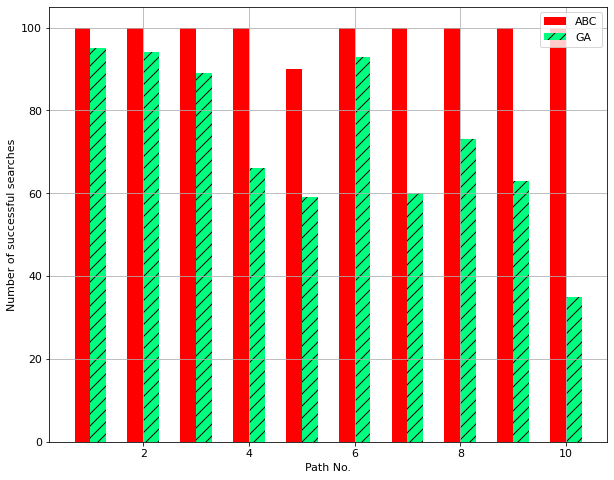

In [8]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
font = {'size'   : 11}
matplotlib.rc('font', **font)
# create data
x = np.arange(K_paths)+1
width = 0.3
  
# plot data in grouped manner of bar type
fig = plt.figure(figsize=(10,8))
plt.bar(x-0.15, solan_1, width, color='red')
plt.bar(x+0.15, solan_2, width, color='springgreen',hatch='//')
plt.xlabel("Path No.")
plt.ylabel("Number of successful searches")
plt.legend(["ABC", "GA"],loc="upper right")
plt.grid()
plt.savefig("ABC_GA_10.png",dpi=200)

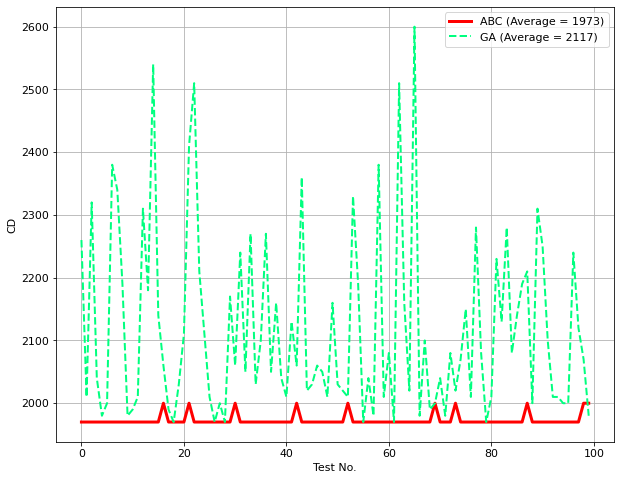

In [9]:
figg1 = plt.figure(figsize=(10,8))
avr_1 = int(sum(CD_1)/Times)
avr_2 = int(sum(CD_2)/Times)
plt.plot(CD_1, label = "ABC" + " (Average = "+str(avr_1)+")", linewidth = '3', color='red')
plt.plot(CD_2, label = "GA" + " (Average = "+str(avr_2)+")", linewidth = '2', color='springgreen', linestyle = 'dashed')
plt.legend(loc="upper right")
plt.xlabel("Test No.")
plt.ylabel("CD")
plt.grid()
plt.savefig("ABC_GA_10_2.png",dpi=200)